In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from data_tools import process_data as process
from data_tools import combine_2023calibration_data as combine
from data_tools import process_dates

# Change as needed
sensor_id = "Fresno"
pmdata = "m_PM25_b"
year = "2023"
data_name = {
    "m_PM25_CF1":{
        "temp": "tempC_pms",
        "rh": "rh_pms",
        "pm1": "m_PM1_CF1",
        "pm2.5": "m_PM25_CF1",
        "name": "Plantower"
    },
    "m_PM25_b":{
        "temp": "tempC_sen5x",
        "rh": "rh_sen5x",
        "pm1": "m_PM1_b",
        "pm2.5": "m_PM25_b",
        "name": "Sensirion"
    }
}
sensor = data_name[pmdata]
training_dates = process_dates.training(sensor_id)
testing_dates= process_dates.testing(sensor_id)

when = {
    "precal_start": training_dates[0],
    "precal_end": training_dates[1],
    "postcal_start": training_dates[2],
    "postcal_end": training_dates[3],
    "trial1_start": testing_dates[0],
    "trial1_end": testing_dates[1],
    "trial2_start": testing_dates[2],
    "trial2_end": testing_dates[3]
}

combined_data, deployment_ref, reference_data = combine.for_calibration(pmdata, sensor_id, training_dates)

# print(combined_data)

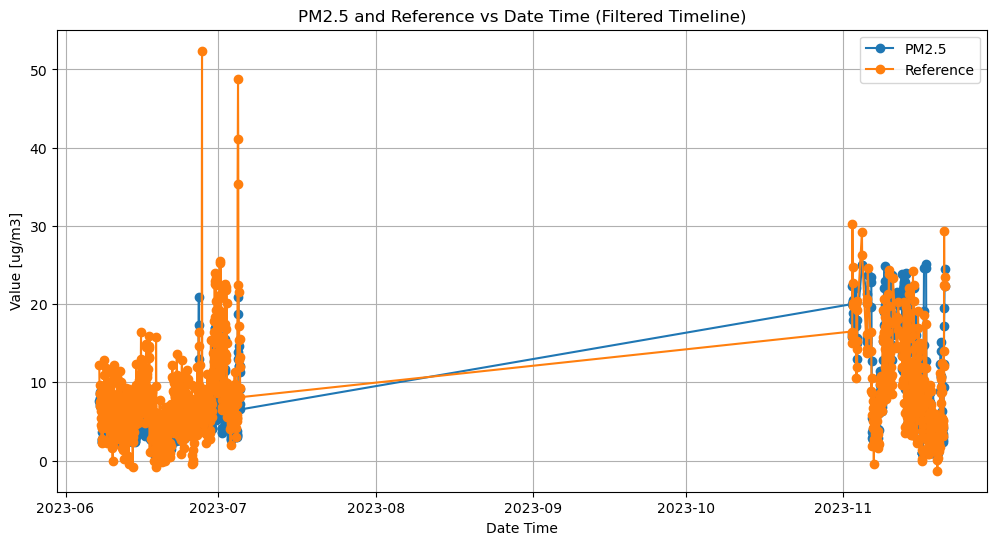

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the start and end dates for the desired timeline
start_date_filter = pd.to_datetime("2023-06-07")
end_date_filter = pd.to_datetime("2023-11-21")

# Apply the date range filter to the merged data
filtered_data = combined_data[(combined_data.index >= start_date_filter) & (combined_data.index <= end_date_filter)]

# Line plot for 'o3' and 'reference' columns against 'date_time' within the specified timeline
plt.figure(figsize=(12, 6))

# Plot 'o3' column
plt.plot(filtered_data.index, filtered_data[sensor["pm2.5"]], label='PM2.5', marker='o')

# Plot 'reference' column
plt.plot(filtered_data.index, filtered_data['reference'], label='Reference', marker='o')

# Customize the plot
plt.title('PM2.5 and Reference vs Date Time (Filtered Timeline)')
plt.xlabel('Date Time')
plt.ylabel('Value [ug/m3]')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
import numpy as np
from data_tools import elastic_net
from data_tools.calibration_formulas.clarity import ClarityCalibrator
# Individual unit remake of Clarity's calibration

clarity = ClarityCalibrator()

combined_data = clarity.add_necessary_variables(combined_data, sensor)

uncalibrated_data = combined_data
reference = combined_data['reference']
variables = [sensor["rh"],sensor["pm2.5"],sensor["pm1"],'temp_minus_dew_point','pm_rh_interaction']
clarity_output = rf"../reference_files/2023rawdata/calibration_variables/{sensor_id}ClarityRemake.csv"

try:
    calibrated_data = elastic_net.calibrate(reference, uncalibrated_data, variables, clarity_output)
    print("Calibrated data:", calibrated_data)
except ValueError as e:
    print("Error:", e)


Number of valid samples after cleaning: 1093
Coefficients (slopes): [-0.          0.40170946  0.39548451  0.10838217 -0.00051654]
Intercept (b0): 1.391474290932683
Calibrated data: (array([ 8.50860032,  9.14500227,  9.49266944, ..., 14.92207546,
       13.48474757, 17.49161516]), array([-0.        ,  0.40170946,  0.39548451,  0.10838217, -0.00051654]), 1.391474290932683)


In [4]:
#elasticnet regression with 2 variables

variables = [sensor["rh"],sensor["pm2.5"]]
twovar_output = rf"../reference_files/2023rawdata/calibration_variables/{sensor_id}2Vars.csv"

try:
    calibrated_data = elastic_net.calibrate(reference, uncalibrated_data, variables, twovar_output)
    print("Calibrated data:", calibrated_data)
except ValueError as e:
    print("Error:", e)



Number of valid samples after cleaning: 1093
Coefficients (slopes): [-0.04538035  0.74742691]
Intercept (b0): 4.9986113374079455
Calibrated data: (array([ 8.61714165,  9.24462337,  9.58666371, ..., 15.07370783,
       13.61266446, 17.61006161]), array([-0.04538035,  0.74742691]), 4.9986113374079455)


In [5]:
from data_tools import handle_datetime
# Load the Excel file containing model parameters
ClarityRemake_df = pd.read_csv(clarity_output)
twoVarCalibration = pd.read_csv(twovar_output)

sensor_file = sensor_file = rf"../reference_files/2023rawdata/{sensor_id}.csv"
calibrated_data = process.standard_data(sensor_file)
# Remove outliers
calibrated_data = calibrated_data[calibrated_data[sensor["pm2.5"]] >= 0]  # Assuming ozone values below 0 are outliers
calibrated_data = calibrated_data[calibrated_data[sensor["pm2.5"]] <= 100]  # Assuming ozone values above 100 are outliers

calibrated_data = handle_datetime.utc_to_CA(calibrated_data)
calibrated_data = clarity.add_necessary_variables(calibrated_data, sensor)

# Add 'month' columns
calibrated_data['week'] = calibrated_data.index.isocalendar().week
calibrated_data['month'] = calibrated_data.index.month

# Function to calibrate PM data using given calibration parameters for model 1
def calibrate_PM_model1(rh, pm25, pm1, tminusdew, pmrh,
                           calibration_params):
    return (rh * calibration_params[0]) + (pm25 * calibration_params[1]) +(pm1 * calibration_params[2]) + (tminusdew * calibration_params[3]) + (pmrh * calibration_params[4]) + calibration_params[5]

# Function to calibrate PM data using given calibration parameters for model 2
def calibrate_PM_model2(rh, pm25, calibration_params):
    return  (rh * calibration_params[0]) + (pm25 * calibration_params[1]) + calibration_params[2]

# Calibration parameters for model 1 for one sensor
calibration_params_model1 = ClarityRemake_df.iloc[0].tolist() # Parameters for Model 1

# Calibration parameters for model 2 for one sensor
calibration_params_model2 = twoVarCalibration.iloc[0].tolist() # Parameters for Model 2

# Apply calibration model 1
calibrated_data['PM_calibrated_ClarityRemake'] = calibrate_PM_model1(calibrated_data[sensor["rh"]], calibrated_data[sensor["pm2.5"]], calibrated_data[sensor["pm1"]], calibrated_data['temp_minus_dew_point'], calibrated_data['pm_rh_interaction'], calibration_params_model1)

# Apply calibration model 2
calibrated_data['PM_calibrated_Basic'] = calibrate_PM_model2(calibrated_data[sensor["rh"]], calibrated_data[sensor["pm2.5"]], calibration_params_model2)

# Save the calibrated data to the same CSV file in two different columns
calibrated_file = rf"../reference_files/{year}{sensor["name"]}DataCalibrated/{sensor_id}_calibrated.csv"
calibrated_data.to_csv(calibrated_file, index=True)

print(f"Calibration complete. File saved as {calibrated_file}.")


Calibration complete. File saved as ../reference_files/2023SensirionDataCalibrated/Fresno_calibrated.csv.


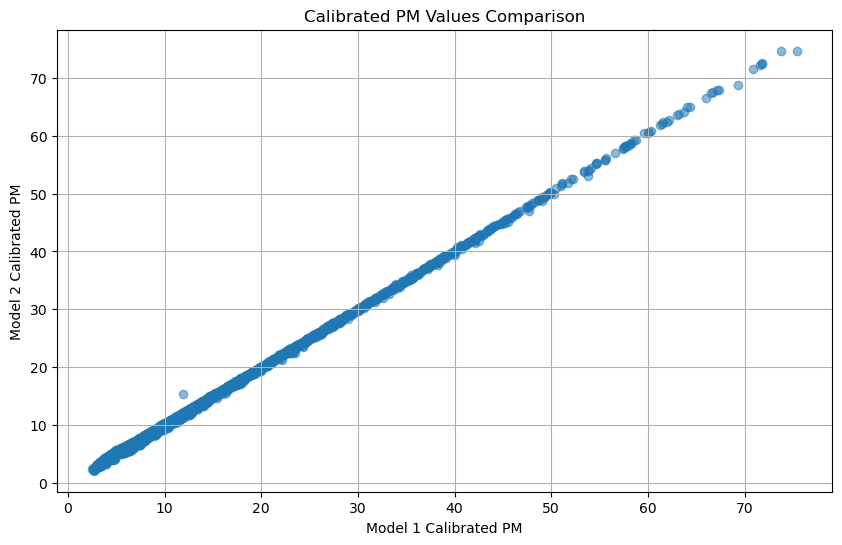

In [6]:
# Load the calibrated data
calibrated_data = process.standard_data(calibrated_file)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(calibrated_data['PM_calibrated_ClarityRemake'], calibrated_data['PM_calibrated_Basic'], alpha=0.5)
plt.title('Calibrated PM Values Comparison')
plt.xlabel('Model 1 Calibrated PM')
plt.ylabel('Model 2 Calibrated PM')
plt.grid(True)
# plt.show()


In [7]:
'''
Universal calibration models for Plantower 
Clarity Calibration Model released on April 23, 2025
Uses variables: rh, temp minus dew (magnus formula), pm rh interaction, pm2.5, pm10, pm1

EPA 2023 Model release mostly for smoke/dust events
Uses variables pm2.5 and rh

Barkjohn EPA 2021 Model 
Uses variables pm2.5 and rh
'''
if sensor["name"] == "Plantower":

    # EPA 2023 Correction (Not good for low PM vals)
    from data_tools.calibration_formulas.epa_2023 import EPA2023Calibrator
    epa_2023 = EPA2023Calibrator()
    calibrated_data = epa_2023.calibrate(calibrated_data)

    # Clarity's PM6003 Calibration (works well even for 5003)
    calibrated_data = clarity.calibrate(calibrated_data)

    # EPA 2021 Correction (Barkjohn's Formula)
    from data_tools.calibration_formulas import epa_barkjohn
    calibrated_data = epa_barkjohn.calibrate(calibrated_data)


In [8]:
# Drops unnecessary data from dataframe for final export

columns = ['unixtime',sensor["pm2.5"],sensor['temp'],sensor['rh'],'temp_C','rh','lat','lon','PM_calibrated_ClarityRemake','PM_calibrated_Basic']
if sensor["name"] == "Plantower":  # replace with your sensor type
    columns += [
        'PM_calibrated_Clarity','PM_calibrated_EPA_Piecewise','PM_calibrated_EPA_Barkjohn'
    ]

calibrated_data_filtered = calibrated_data[columns]

calibrated_data_filtered.to_csv(calibrated_file, index=True)

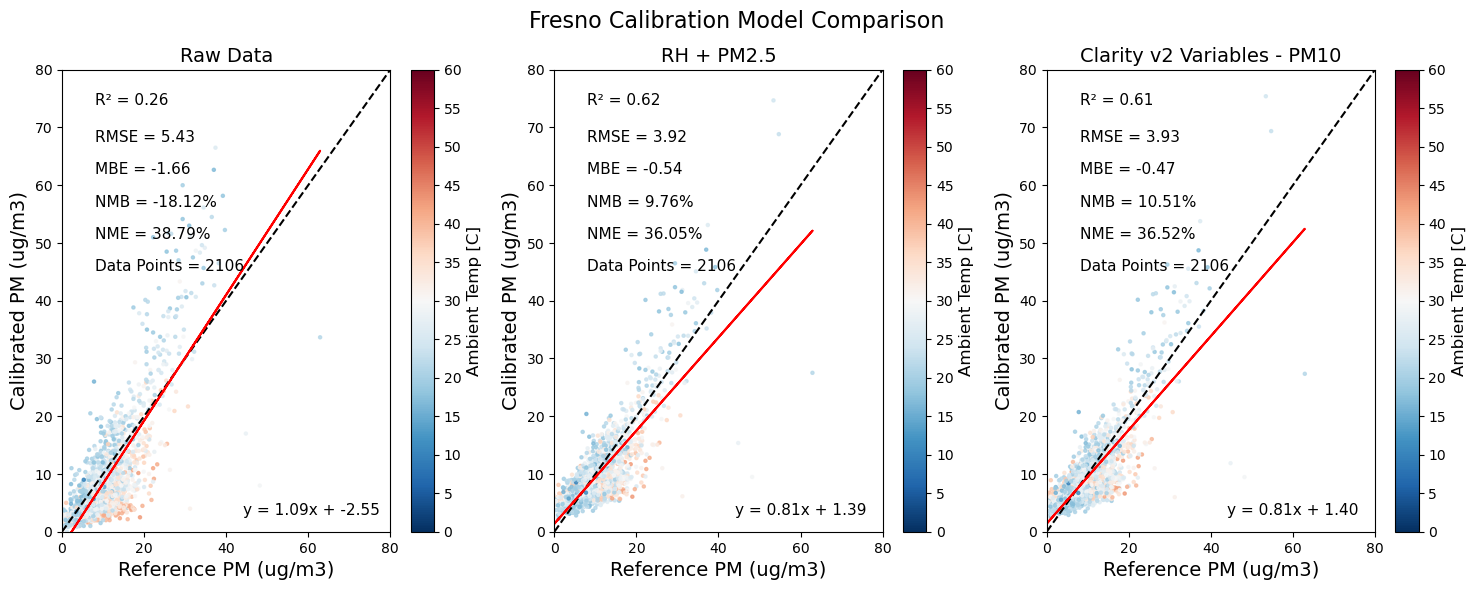

In [9]:
from data_tools.plot_against_reference import PlotPlantower
from data_tools.plot_against_reference import PlotSensirion
ps = PlotSensirion()
ptw = PlotPlantower()
# For early summer
precal_data = calibrated_data.loc[when["precal_start"]:when["precal_end"]]
precal_merged = precal_data.join(reference_data['reference'], how='inner')

# For fall
postcal_data = calibrated_data.loc[when["postcal_start"]:when["postcal_end"]]
if sensor_id == "Tranquility":
    postcal_merged = postcal_data.join(deployment_ref['reference'], how='inner')
else:
    postcal_merged = postcal_data.join(reference_data['reference'], how='inner')

trial1_data = calibrated_data.loc[when["trial1_start"]:when["trial1_end"]]
trial1_merged = trial1_data.join(deployment_ref['reference'], how='inner')

trial2_data = calibrated_data.loc[when["trial2_start"]:when["trial2_end"]]
trial2_merged = trial2_data.join(deployment_ref['reference'], how='inner')

merged_data_yearround = pd.concat([trial1_merged, trial2_merged])
#merged_data_yearround = pd.concat([precal_merged, postcal_merged])

# Base columns to always drop NAs for
dropna_cols = [
    'reference',
    sensor["pm2.5"],
    'PM_calibrated_Basic',
    'PM_calibrated_ClarityRemake'
]

# Conditionally add EPA columns
if sensor["name"] == "Plantower":
    dropna_cols += [
        'PM_calibrated_Clarity','PM_calibrated_EPA_Piecewise','PM_calibrated_EPA_Barkjohn'
    ]

# Drop rows with NA in any of the relevant columns
merged_data_yearround.dropna(subset=dropna_cols, inplace=True)

if(sensor["name"] == "Plantower"):
    PlotPlantower.plot(merged_data_yearround,f"{sensor_id}")
else:
    ps.plot(merged_data_yearround,sensor_id)

In [10]:
# import matplotlib.dates as mdates
# from scipy import stats
# import numpy as np

# # Line plot for 'o3' and 'reference' columns against 'date_time' within the specified timeline
# plt.figure(figsize=(8, 12))

# start_date = pd.to_datetime("2023-08-14")
# end_date = pd.to_datetime("2023-12-16")

# merged_data_yearround = pd.concat([precal_merged, trial1_merged, trial2_merged, postcal_merged])

# # Drop rows with missing values in the columns of interest
# merged_data_yearround.dropna(subset=['reference', 'PM_calibrated_Basic', 'PM_calibrated_ClarityRemake', 'm_PM25_CF1', 'PM_calibrated_EPA_Piecewise', 'PM_calibrated_EPA_Barkjohn', 'PM_calibrated_Clarity'], inplace=True)

# merged_data_yearround['ratio'] = merged_data_yearround['PM_calibrated_ClarityRemake']/merged_data_yearround['reference']

# merged_data_yearround_filtered = merged_data_yearround.loc[start_date:end_date]

# merged_data_yearround_filtered['day_counter'] = (
#     (merged_data_yearround_filtered.index - merged_data_yearround_filtered.index[0])
#     / pd.Timedelta(days=1)
# )
# x = merged_data_yearround_filtered['day_counter']
# y = merged_data_yearround_filtered['ratio']

# slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
# y_fit = slope * x + intercept
# print(x)
# fig, ax = plt.subplots()

# # Plot 'o3' column
# plt.plot(x, y, marker='o', color='orange', label="ratio")
# plt.hlines(y=1, xmin=merged_data_yearround_filtered['day_counter'][0], xmax=merged_data_yearround_filtered['day_counter'][len(merged_data_yearround_filtered)-1], color='green', linestyle='-', label="Y = 1")
# # Customize the plot
# plt.title('CCEJN AQLite Validated Against CARB Monitor')
# plt.xlabel('Date')
# plt.ylabel('AQLite Ozone over Reference Ozone')
# plt.ylim(0, 15)
# plt.legend()
# plt.grid(True)

# # Set major ticks to the first of each month
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# # # Optional: minor ticks for better granularity
# # ax.xaxis.set_minor_locator(mdates.DayLocator())  # Mondays
# # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))

# # Improve label spacing
# fig.autofmt_xdate()

# plt.show()

In [11]:
# # === Optionally filter by date range ===
# start_date = pd.to_datetime("2023-06-09")
# end_date = pd.to_datetime("2023-06-15")

# calibrated_data_filtered = calibrated_data[(calibrated_data.index >= start_date) & (calibrated_data.index <= end_date)]
# ref_filtered = reference_data[(reference_data.index >= start_date) & (reference_data.index <= end_date)]

# # === Plotting ===
# plt.figure(figsize=(12, 6))

# # Plot CSV data
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_Clarity'], label='Clarity Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_ClarityRemake'], label='Clarity Remake Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_EPA_Piecewise'], label='EPA 2023 Calibration', marker='o')
# plt.plot(calibrated_data_filtered.index, calibrated_data_filtered['PM_calibrated_EPA_Barkjohn'], label='EPA 2021 Calibration', marker='o')

# # Plot reference data
# plt.plot(ref_filtered.index, ref_filtered['reference'], label='Reference Data', marker='x')

# plt.title(f'{sensor_id} VOZbox vs. FEM')
# plt.xlabel('Date')
# plt.ylabel('PM [ug/m3]')
# plt.ylim(0, 30)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# # plt.savefig(rf"./images/{sensor_id}CalibratedGraph.jpg", format='jpg', dpi=300)
# # plt.show()

In [12]:
# import requests
# import pandas as pd

# API_KEY = "C776CB92-8D28-11F0-BDE5-4201AC1DC121"

# # Central Valley bounding box (rough example)
# # lat_min, lat_max, lon_min, lon_max

# lat_min, lat_max = 35.491750, 36.813374
# lon_min, lon_max = -120.501901, -118.897490

# url = "https://api.purpleair.com/v1/sensors"

# params = {
#     "fields": "latitude,longitude,pm2.5,temperature,humidity",
#     "location_type": 0,  # outside only
#     "nwlng": lon_min,
#     "nwlat": lat_max,
#     "selng": lon_max,
#     "selat": lat_min
# }

# headers = {"X-API-Key": API_KEY}

# resp = requests.get(url, params=params, headers=headers).json()

# # Convert to DataFrame
# sensors = pd.DataFrame(resp["data"], columns=resp["fields"])
# sensors.to_csv("central_valley_purpleair_sensors.csv", index=False)
# print(sensors)